# 语音分析

一般来讲，语音信号的采样率是挺高的，而且认为语音信号在一定时间段的基本特性不会发生较大的变化，具有一定的短时平稳性。进行“短时分析”就行将信号分解成一段一段地来处理，每一段就叫一帧，大约10~30ms，也就是一秒钟大约33~100帧，对于通常10K的采样率来说，这样也能有一定的信息存在。分帧通常有一定的交叠部分，就是帧移。帧移与帧长的比通常为0~1/2。

分帧就是通过加窗函数实现的，假设原始信号为$s(n)$，窗函数为$w(n)$，那么分帧就是$s_w(n)=s(n)*w(n)$，窗函数需要满足1. 窗口两端不引起急剧变化，应该平滑过渡到0，2.在频域有较宽的3dB贷款以及较大的边带最大值。窗口的长度一般为10~20ms。有三种常见的窗函数为：

- 矩形窗
  $$w(n)=\left\{\begin{array}{ll}
   1&,0\leqslant n \leqslant N-1\\
   0&,others
  \end{array}\right. \tag{矩形窗}$$
  
- 汉明窗
  

$$w(n)=\left\{\begin{array}{ll}
 0.54-0.46\cos[2\pi n/(N-1)]&,0\leqslant n \leqslant N-1\\
 0&,others
\end{array}\right.\tag{汉明窗}$$

- 海宁窗

$$w(n)=\left\{\begin{array}{ll}
 0.5(1-\cos(2\pi n/(N-1)))&,0\leqslant n \leqslant N-1\\
 0&,others
\end{array}\right.\tag{汉明窗}$$


其图形如下：

![.\images\window.png](images/window.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

N = 32
nn = [i for i in range(N)]
plt.subplot(3, 1, 1)
plt.stem(np.ones(N))
plt.title('(a)矩形窗')

w = 0.54 - 0.46 * np.cos(np.multiply(nn, 2 * np.pi) / (N - 1))
plt.subplot(3, 1, 2)
plt.stem(w)
plt.title('(b)汉明窗')

w = 0.5 * (1 - np.cos(np.multiply(nn, 2 * np.pi) / (N - 1)))
plt.subplot(3, 1, 3)
plt.stem(w)
plt.title('(c)海宁窗')
# plt.show()
plt.savefig('images/window.png')
plt.close()

分帧操作，相当于将信号分解为若干个信号片段，并将片段与窗函数进行对应元素的乘法。

In [5]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def enframe(x, win, inc=None):
    nx = len(x)
    if isinstance(win, list):
        nwin = len(win)
        nlen = nwin  # 帧长=窗长
    elif isinstance(win, int):
        nwin = 1
        nlen = win  # 设置为帧长
    if inc is None:
        inc = nlen
    nf = (nx - nlen + inc) // inc
    frameout = np.zeros((nf, nlen))
    indf = np.multiply(inc, np.array([i for i in range(nf)]))
    for i in range(nf):
        frameout[i, :] = x[indf[i]:indf[i] + nlen]
    if isinstance(win, list):
        frameout = np.multiply(frameout, np.array(win))
    return frameout


fs, data = wavfile.read('./data/C3_1_y.wav')
inc = 100
wlen = 200
en = enframe(data, wlen, inc)
# i = input('其实帧(i):')
# 将波形切分成4帧
i = 4
tlabel = i
plt.subplot(4, 1, 1)
x = [i for i in range((tlabel - 1) * inc, (tlabel - 1) * inc + wlen)]
plt.plot(x, en[tlabel, :])
plt.xlim([(i - 1) * inc + 1, (i + 2) * inc + wlen])
plt.title('(a)当前波形帧号{}'.format(tlabel))

plt.subplot(4, 1, 2)
x = [i for i in range((tlabel + 1 - 1) * inc, (tlabel + 1 - 1) * inc + wlen)]
plt.plot(x, en[i + 1, :])
plt.xlim([(i - 1) * inc + 1, (i + 2) * inc + wlen])
plt.title('(b)当前波形帧号{}'.format(tlabel + 1))

plt.subplot(4, 1, 3)
x = [i for i in range((tlabel + 2 - 1) * inc, (tlabel + 2 - 1) * inc + wlen)]
plt.plot(x, en[i + 2, :])
plt.xlim([(i - 1) * inc + 1, (i + 2) * inc + wlen])
plt.title('(c)当前波形帧号{}'.format(tlabel + 2))

plt.subplot(4, 1, 4)
x = [i for i in range((tlabel + 3 - 1) * inc, (tlabel + 3 - 1) * inc + wlen)]
plt.plot(x, en[i + 3, :])
plt.xlim([(i - 1) * inc + 1, (i + 2) * inc + wlen])
plt.title('(d)当前波形帧号{}'.format(tlabel + 3))

# plt.show()
plt.savefig('images/en.png')
plt.close()



![分帧](images/en.png)

另外，也可以直接使用`numpy.hanning(N)`来获得窗函数。其中N就是点数。

## 短时时域分析

时域分析就是提取语音信号的时域参数。时域分析通常用于最基本的参数分析与应用，如语音分割，预处理，分类等。常用的时域参数有短时能量，短时过零率，短时自相关系数和短时平均幅度差函数等。
1. 短时能量与短时平均幅度
   
设第$n$帧语音信号$x_n(m)$的短时能量用$E_n$表示：
$$E_n=\sum\limits_{m=1}^Nx_n^2(m)$$

$E_n$是度量语音信号幅度值变化的函数，对高电平非常敏感（用平方计算的）。可以用短时平均幅度函数$M_n$:
$$M_n=\sum\limits_{m=1}^N|x_n(m)|$$

$M_n$也是一帧语音信号的能量大小的表征，不会应该平方造成较大差异。

2. 短时过零率
   
表示一帧语音信号波形穿过横轴的次数。也就是前后一个样本点符号变化的次数。
$$Z_n=\frac{1}{2}\sum\limits_{m=1}^N|sgn[x_n(m)]-sgn[x_n(m-1)]|$$

在实际计算那种，由于信号中可能有50Hz的工频干扰或偏移量，计算的过零率参数往往不准确，所以在A/D转换前的防混叠带通滤波器的低端截止频率要高于50Hz，抑制电源干扰。在软件上去质量偏量，或者采用低直流漂移量元件。实际在计算过零率时候，还可以使用$x_i(m)*x_i(m+1)<0$来判断。

3. 短时自相关

自相关函数具有一些性质（如偶函数，如果序列是有周期性，自相关函数也有周期性）。对于浊音可以用自相关函数求出基音周期。在进行语音信号的预测分析时，也要用到自相关函数。语音信号$x_n(m)$的自相关函数$R_n(k)$可以表示为：
$$R_n(k)=\sum\limits_{m=1}^{N-k}x_n(m)x_n(m+k)，其中(0\leqslant k \leqslant K)$$

K为最大延迟点数。短时自相关函数的性质有：
  - 如果$x_n(m)$是周期的，假设周期为$N_p$，则自相关函数是同周期的周期函数，即$R_n(k)=R_n(k+N_p)$
  - $R_n(k)$是偶函数，即$R_n(k)=R_n(-k)$
  - 当$k=0$时，自相关函数具有最大值，即$R_n(0)\geqslant |R_n(k)|$，并且$R_n(0)$等于确定性信号序列的能量或随机性序列的平均功率。

4. 短时平均幅度差

短时自相关函数是语言信号分析的重要参量，但是计算自相关喊得运算非常大，为了避免乘法，一个简单的方法就是利用差值，即短时平均幅度差函数。因为如果信号是周期(周期为$N_p$)的，则相距的周期的整数倍的样本点的幅值是相等的，差值为0。
$$d(n)=x(n)-x(n+k)=0,(k=0,±N_p,±2N_p,...)$$

实际语音信号$d(n)$不为零，是一个很小的值。可定义短时平均幅度差为：
$$F_n(k)=\sum\limits_{m=1}^{N-k}|x_n(m)-x_n(m+k)|$$

如果$x(n)$在窗口范围内，具有周期性，则$F_n(k)$在$k=0,±N_p,±2N_p,...$时将出现极小值。平均幅度差函数与自相关喊得关系为：
$$F_n(k)=\sqrt{2}\beta(k)[R_n(0)-R_n(k)]^{1/2}$$

其中$\beta(k)$在不同的语音段在0.6~1.0之间变化，但是对一个特定的语音段，他随着$k$值的变化并不明显。

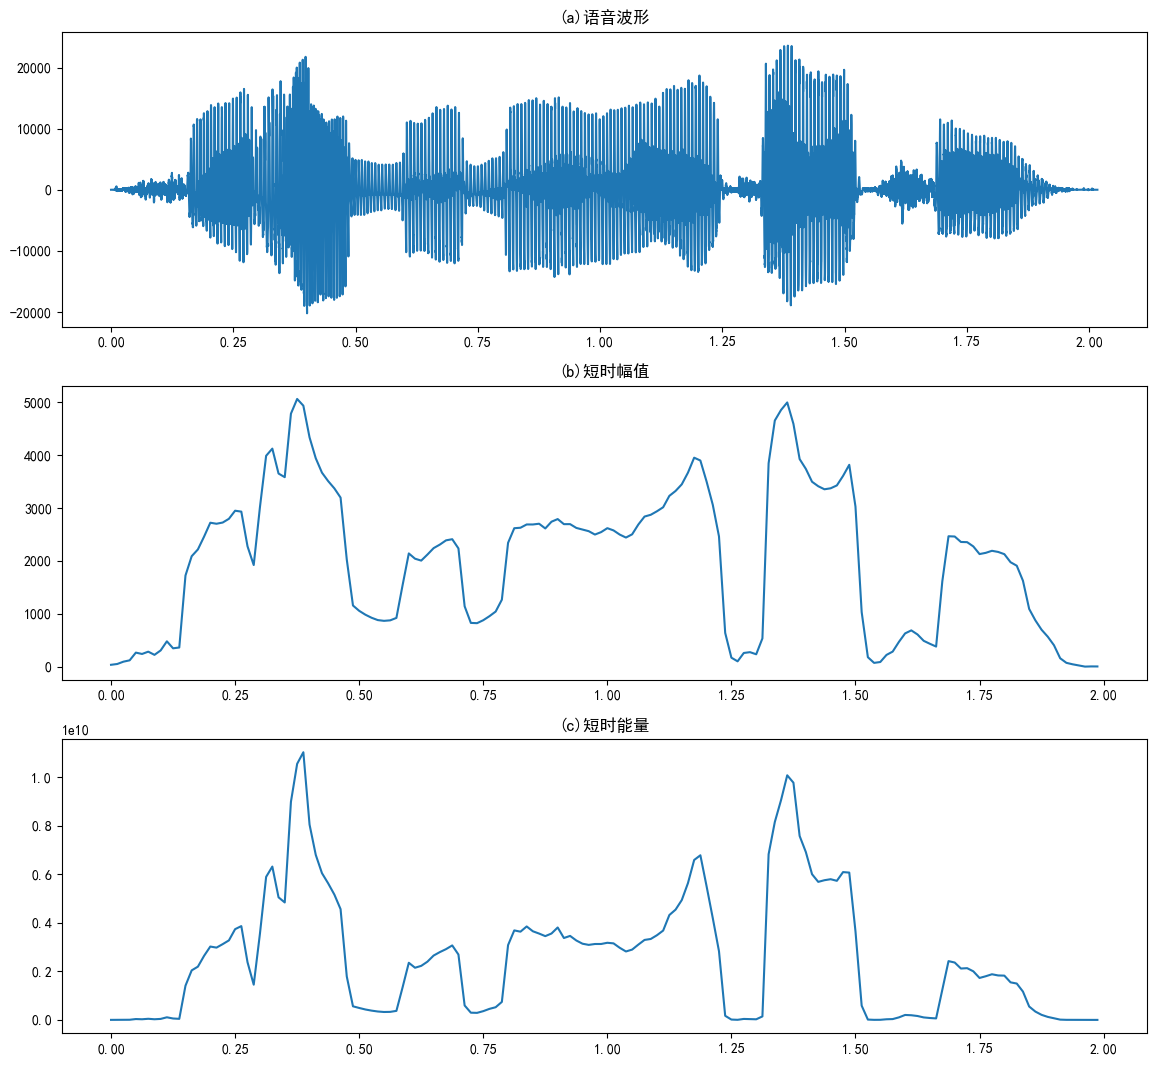

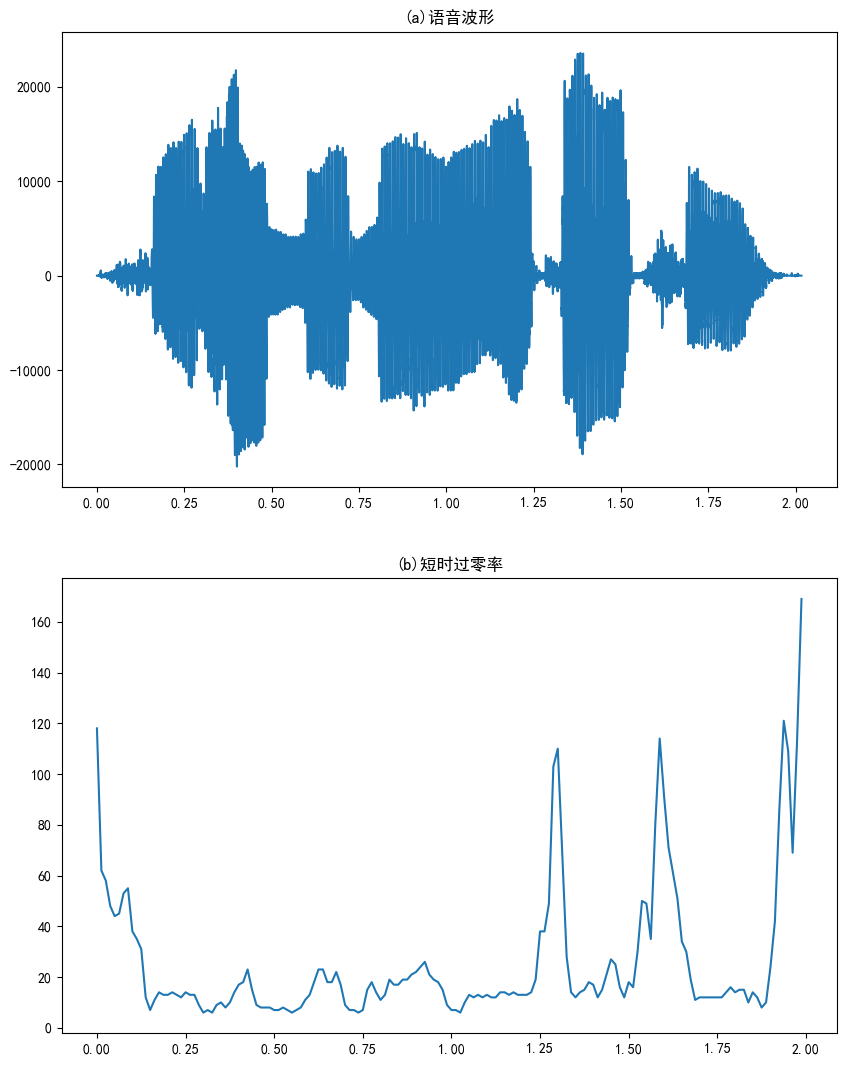

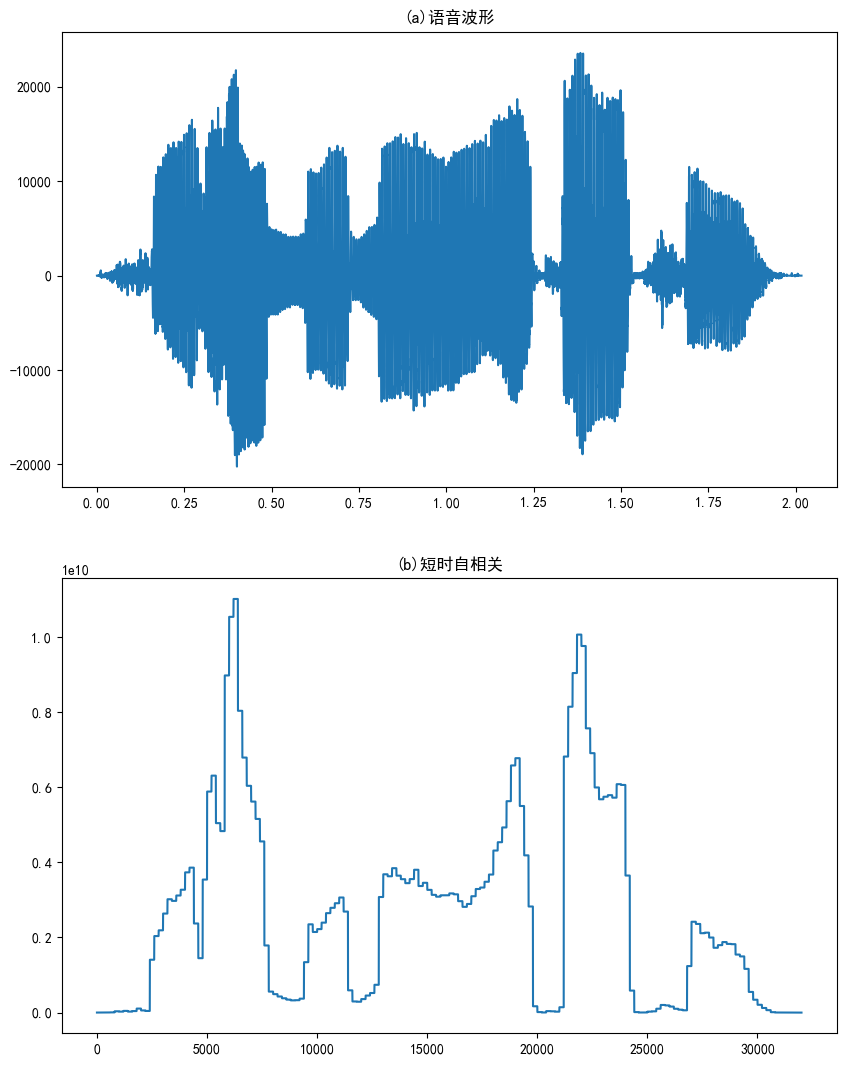

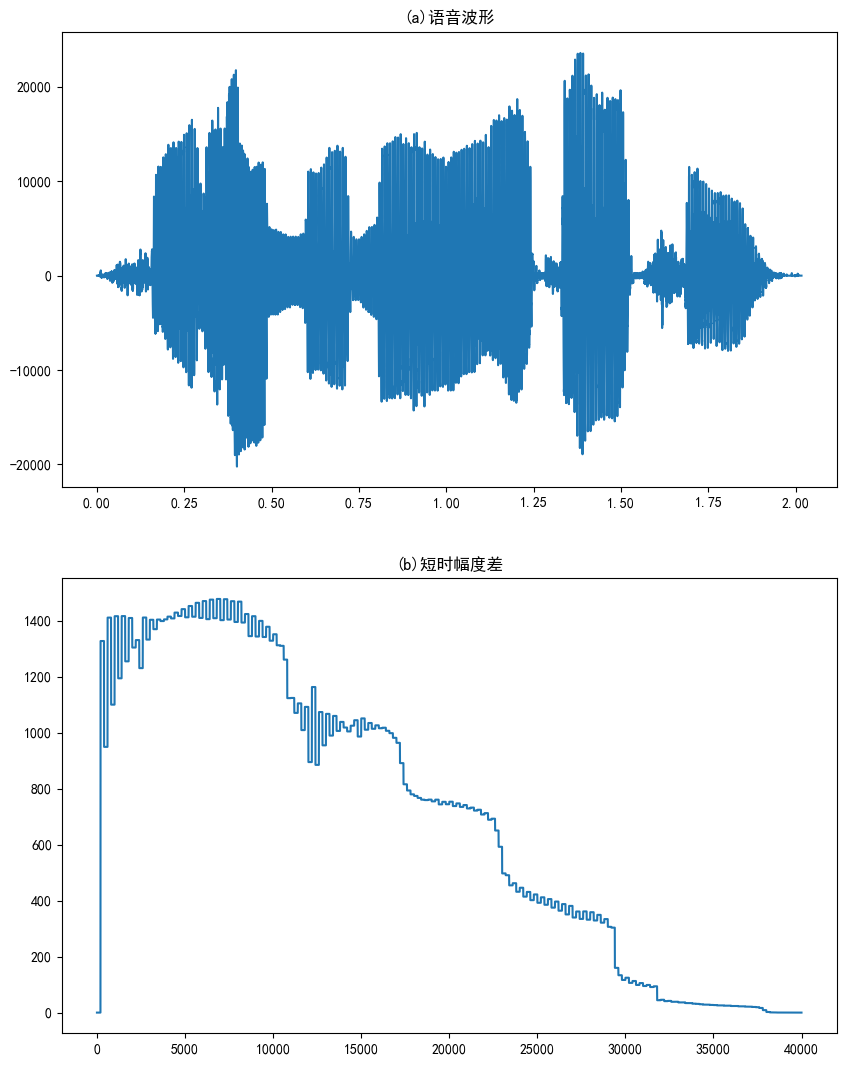

In [3]:
# C3_2_y.py
from scipy.io import wavfile
import matplotlib.pyplot as plt
from utils.windows import *
from utils.timefeature import *
from utils.soundBase import *


# data, fs = soundBase('./data/C3_2_y.wav').audioread() # 原来的读取方法，出错，就直接修改了。
fs, data = wavfile.read('./data/C3_2_y.wav') 
inc = 100
wlen = 200
win = hanning_window(wlen)
N = len(data)
time = [i / fs for i in range(N)]

EN = STEn(data, win, inc)  # 短时能量
Mn = STMn(data, win, inc)  # 短时平均幅度
Zcr = STZcr(data, win, inc)  # 短时过零率

X = enframe(data, win, inc)
X = X.T
Ac = STAc(X)
Ac = Ac.T
Ac = Ac.flatten()

Amdf = STAmdf(X)
Amdf = Amdf.flatten()

fig = plt.figure(figsize=(14, 13))
plt.subplot(3, 1, 1)
plt.plot(time, data)
plt.title('(a)语音波形')
plt.subplot(3, 1, 2)
frameTime = FrameTimeC(len(EN), wlen, inc, fs)
plt.plot(frameTime, Mn)
plt.title('(b)短时幅值')
plt.subplot(3, 1, 3)
plt.plot(frameTime, EN)
plt.title('(c)短时能量')
plt.savefig('images/energy.png')

fig = plt.figure(figsize=(10, 13))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.title('(a)语音波形')
plt.subplot(2, 1, 2)
plt.plot(frameTime, Zcr)
plt.title('(b)短时过零率')
plt.savefig('images/Zcr.png')

fig = plt.figure(figsize=(10, 13))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.title('(a)语音波形')
plt.subplot(2, 1, 2)
plt.plot(Ac)
plt.title('(b)短时自相关')
plt.savefig('images/corr.png')

fig = plt.figure(figsize=(10, 13))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.title('(a)语音波形')
plt.subplot(2, 1, 2)
plt.plot(Amdf)
plt.title('(b)短时幅度差')
plt.savefig('images/Amdf.png')


## 短时傅里叶变换

语音信号是典型的非平稳信号，但是由于其非平稳性由发声器官的物理运动过程而产生，这种过程是相对变换缓慢的，在10~30ms以内可以认为是平稳的。傅里叶分析时分析线性系统和平稳信号稳态特征的手段，而短时傅里叶分析，是用稳态分析方法处理非平稳信号的一种方法。

假设语音波形时域信号为$x(l)$,加窗分帧处理后得到的第$n$帧语音信号为$x_n(m)$,那有：
$$x_n(m)=w(m)x(n+m),1\leqslant m\leqslant N$$

对分帧信号进行短时傅里叶变化就是：
$$X_n(e^{jw})=\sum\limits_{m=1}^Nx_n(m)e^{-jwm}$$

其中，定义角频率$w=2\pi k/N$，得到了离散的短时傅里叶变化(DFT)。实际上就是$X_n(e^{jw})$在频域的取样：
$$X_n(e^{j\frac{2\pi k}{N}})=X_n(k)=\sum\limits_{m=1}^Nx_n(m)e^{-j\frac{2\pi km}{N}},1\leqslant k \leqslant N$$

实际中，可以使用FFT算法代替换成$x_n(m)$到$X_n(k)$的转换。

In [4]:
def STFFT(x, win, nfft, inc):
    xn = enframe(x, win, inc)
    xn = xn.T
    y = np.fft.fft(xn, nfft, axis=0)
    return y[:nfft // 2, :]

输入数据首先分帧处理，使用之前创建过的函数`enframe(x, win, inc)`。然后直接调用`np.fft.fft(xn, nfft, axis=0)`进行fft变化处理，中间有一个转置操作，是为了让时间轴作为横坐标，k作为纵坐标。

## 语谱图的表示

一般定义$|X_n(k)|$为$x_n(m)$的短时幅度谱估计，而时间处频谱能量密度函数$P(n,k)$表示为：
$$P(n,k)=|X_n(k)|^2$$

可以看出$P(n,k)$是一个非负的实数矩阵，以时间n作为横坐标，k作为纵坐标，就可以绘制一张热图（或灰度图），这就是语谱图。如果通过$10\lg P(n,k)$处理后，语谱图的单位就是dB，将变换后的矩阵精细图像和色彩映射后，就能得到彩色的语谱图。

语谱图中的横杠表示他们是共振峰，从横杠对应的频率和宽度可以确定相应的共振峰的频率域带宽，在一个语音段中，有没有横杠的出现是判断是不是浊音的重要标志。竖条是语谱图中与时间轴垂直的条纹，每个竖直条表示一个基音，条纹的起点相当于声门脉冲的起点，条纹之间的距离表示基音周期。

在python中，读取到语音信号以后可以直接使用

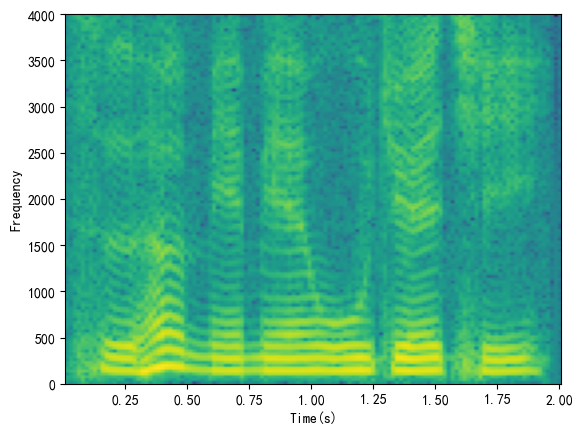

In [5]:
plt.specgram(data, NFFT=256, Fs=fs, window=np.hanning(256))
plt.ylabel('Frequency')
plt.xlabel('Time(s)')
plt.show()

进行绘制语谱图，如果想要使用短时傅里叶变化得到的结果来做，那么首先看下输出的结果是一个复数矩阵，所以先求模后平方`np.abs(y)*np.abs(y)`，那么用`plt.matshow`可以得到结果，不过这样的语谱图上下颠倒的，使用`np.flip(np.abs(y)*np.abs(y), 0))`上数据上下翻转一下。在绘制之前最好转化为dB单位，就是以10取对数，不然啥也看不见，黑乎乎一片。

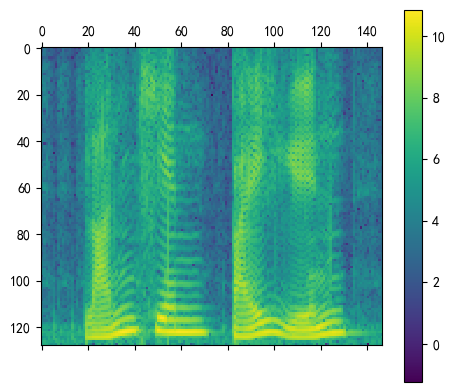

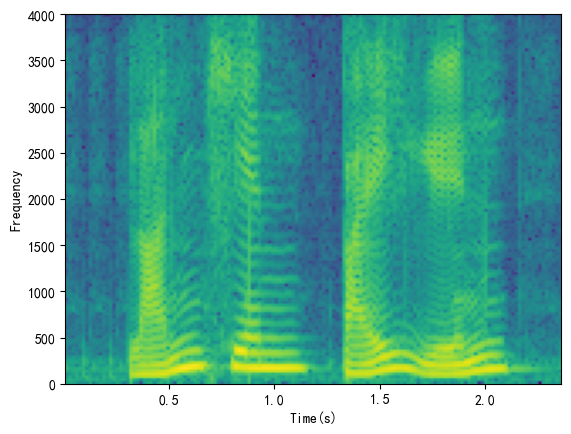

In [6]:
from utils.windows import *
from utils.timefeature import *
from utils.soundBase import *


def STFFT(x, win, nfft, inc):
    xn = enframe(x, win, inc)
    xn = xn.T
    y = np.fft.fft(xn, nfft, axis=0)
    return y[:nfft // 2, :]


# data, fs = soundBase('C3_3_y.wav').audioread() # 原来的读取方法，出错，就直接修改了
fs, data = wavfile.read('./data/C3_3_y.wav') 

wlen = 256
nfft = wlen
win = hanning_window(wlen)
inc = 128

y = STFFT(data, win, nfft, inc)
freq = [i * fs / wlen for i in range(wlen // 2)]
frame = FrameTimeC(y.shape[1], wlen, inc, fs)

plt.matshow(np.log10(np.flip(np.abs(y)*np.abs(y), 0)))
plt.colorbar()
plt.show()

plt.specgram(data, NFFT=256, Fs=fs, window=np.hanning(256))
plt.ylabel('Frequency')
plt.xlabel('Time(s)')
plt.show()

得到的语谱图大约是这样的：

![spec](images/spec.png)

## 倒谱分析

语音信号$x(n)$可以看做是声门激励信号$x_1(n)$和声道冲击响应信号$x_2(n)$的卷积：
$$x(n)=x_1(n)*x_2(n)$$

为了便于处理卷积，系统通常采用同态处理的方式做卷积，将卷积关系变换为求和关系：

![同态](images/同态.png)

上图中`*`,`+`,`·`分别表示卷积，加法，乘法运算。第一个子系统中$D_*[]$完成卷积性信号转化为加性信号的运算，对信号$x(n)=x_1(n)*x_2(n)$进行一下处理：
$$\left\{\begin{array}{ll}
    Z[x(n)]=X(z)=X_1(z)*X_2(z)\\
    \ln(X(z))=\ln(X_1(z))+\ln(X_2(z))=\hat{X_1}(z)+\hat{X_2}(z)=\hat{X}(z)\\
    Z^{-1}[\hat{X}(z)]=Z^{-1}[\hat{X_1}(z)+\hat{X_2}(z)]=\hat{x_1}(n)+\hat{x_2}(n)=\hat{x}(n)
\end{array}\right.$$

第二个子系统是一个普通的线性系统，满足线性叠加原理，$\hat x(n)$是加性信号，可以对信号进行需要的线性变换得到$\hat y(n)$。

第三个子系统是逆特征系统$D_*^{-1}[]$，他对$\hat y(n)=\hat{y_1}(n)+\hat{y_2}(n)$进行逆变换，使其恢复卷积性信号。处理方式为：
$$\left\{\begin{array}{ll}
    Z[\hat y(n)]=\hat Y(z)=\hat Y_1(z)* \hat Y_2(z)\\
    \exp(\hat Y(z))=Y(z)=\hat{Y_1}(z)+\hat{Y_2}(z)\\
    y(n)=Z^{-1}[\hat{Y_1}(z)+\hat{Y_2}(z)]=y_1(n)*y_2(n)
\end{array}\right.$$

$\hat x(n)$和$\hat y(n)$也是时域序列，但是他们与$x(n)$和$y(n)$所处的时域不同，称为复倒频谱域。$\hat x(n)$是$x(n)$的复倒频谱域，简称复倒频。表示为：$\hat x(n)=Z^{-1}[\ln Z[x(n)]]$。$D_*[]$与$D_*^{-1}[]$系统有：
$$D_*[]:\left\{\begin{array}{ll}
    F[x(n)]=X(e^{jw})\\
    \hat X(e^{jw})=\ln [X(e^{jw})]\\
    \hat x(n)=F^{-1}[\hat X(e^{jw})]
\end{array}\right.$$

$$D_*^{-1}[]:\left\{\begin{array}{ll}
    \hat Y(e^{jw})=F[\hat y(n)]\\
    Y(e^{jw})=\exp [\hat Y(e^{jw})]\\
    y(n)=F^{-1}[\hat Y(e^{jw})]
\end{array}\right.$$

设$X(e^{jw})=|X(e^{jw})|e^{j\arg[X(e^{jw})]}$，取对数有：
$$\hat X(e^{jw})=\ln |X(e^{jw})|+j\arg[X(e^{jw})]$$

值考虑$\hat X(e^{jw})$的实部，有：
$$c(n)=F^{-1}[\ln|X(e^{jw})|]$$

$c(n)$是对数谱的逆傅里叶变换，称为倒频谱，简称倒谱。由于浊音信号的倒谱纯在峰值，出现位置等于该语音段的基音周期，而清音的倒谱中不存在峰值。这个特性可用于清浊音的判断，而且可以估计浊音的基音周期。
得到数学公式以后，倒谱的计算也就变得容易实现了。只需要借助numpy的fft就可以快速实现。

In [ ]:
import numpy as np


def cceps(x):
    """
    计算复倒谱
    """
    y = np.fft.fft(x)
    return np.fft.ifft(np.log(y))


def icceps(y):
    """
    计算复倒谱的逆变换
    """
    x = np.fft.fft(y)
    return np.fft.ifft(np.exp(x))


def rcceps(x):
    """
    计算实倒谱
    """
    y = np.fft.fft(x)
    return np.fft.ifft(np.log(np.abs(y)))

如下图就是得到一个信号的倒谱，并可以重构回去。

![倒谱](images/倒谱.png)

## 离散余弦变换

离散余弦变换（Discrete Cosine Transform, DCT）具有信号谱十分丰富，能量集中，在较低的运算复杂度下可以取得较好的语音增强效果。
假设$x(n)$是N个有限值的一维实数信号序列，$n=1,2,...,N-1$，DCT的完备正交归一函数就是：

$$\left\{\begin{array}{ll}
    X(k)=a(k)\sum\limits_{n=0}^{N-1}x(n)\cos(\frac{(2n+1)k\pi}{2N})\\
    x(n)=\sum\limits_{n=0}^{N-1}a(k)X(k)\cos(\frac{(2n+1)k\pi}{2N})
\end{array}\right.$$
其中$a(k)$为：
$$a(k)=\left\{\begin{array}{ll}
    \sqrt{1/N}&,k=0\\
    \sqrt{2/N}&,k\in[1,N-1]
\end{array}\right.$$

将上面的式子变换为：
$$X(k)=\sqrt{\frac{2}{N}}\sum\limits_{n=0}^{N-1}C(k)x(n)\cos(\frac{(2n+1)k\pi}{2N}),k=0,1,...,N-1\tag{DCT}$$

$C(k)$是正交因子。
$$C(k)=\left\{\begin{array}{ll}
    \sqrt{2}/2&,k=0\\
    1&,k\in[1,N-1]
\end{array}\right.$$

DCT的逆变换为：
$$x(n)=\sqrt{\frac{2}{N}}\sum\limits_{n=0}^{N-1}C(k)X(k)\cos(\frac{(2n+1)k\pi}{2N}),k=0,1,...,N-1$$

In [1]:
# 离散余弦变换
import numpy as np


def dct(x):
    N = len(x)
    X = np.zeros(N)
    ts = np.array([i for i in range(N)])
    C = np.ones(N)
    C[0] = np.sqrt(2) / 2
    for k in range(N):
        X[k] = np.sqrt(2 / N) * np.sum(C[k] * np.multiply(x, np.cos((2 * ts + 1) * k * np.pi / 2 / N)))
    return X


def idct(X):
    N = len(X)
    x = np.zeros(N)
    ts = np.array([i for i in range(N)])
    C = np.ones(N)
    C[0] = np.sqrt(2) / 2
    for n in range(N):
        x[n] = np.sqrt(2 / N) * np.sum(np.multiply(np.multiply(C[ts], X[ts]), np.cos((2 * n + 1) * np.pi * ts / 2 / N)))
    return x


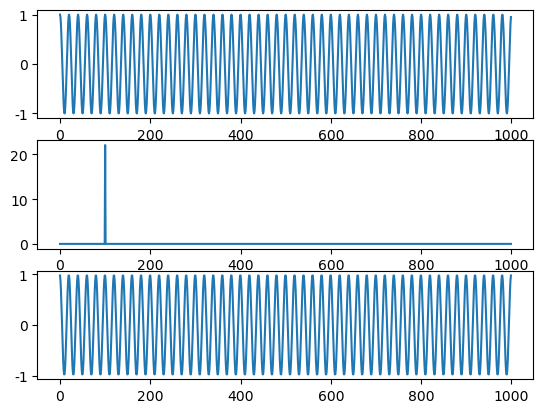

In [2]:
from utils.soundBase import *
from utils.dct import *

f = 50
fs = 1000
N = 1000
n = np.array([i for i in range(N)])

xn = np.cos(2 * np.pi * f * n / fs)
y = dct(xn)
y = np.where(abs(y) < 5, 0, y)

zn = idct(y)

plt.subplot(3, 1, 1)
plt.plot(xn)
plt.subplot(3, 1, 2)
plt.plot(y)
plt.subplot(3, 1, 3)
plt.plot(zn)
plt.show()


![dct](images/dct.png)


## 梅尔频率倒谱系数
梅尔频率倒谱系数（Mel-Frequency Cepstral Coefficients, MFCC）分析是基于人的听觉特性机理，即根据人的听觉试验结果来分析语音的频谱，因为人耳听到的声音的高低与声音的频率不成线性正比关系。美尔频率尺度的值大体上对应实际频率的对数分布关系，其与实际频率的具体关系可表示为：
$$F_{Mel}(f)=1125\ln(1+f/700)$$

其中，$F_{Mel}$是以美尔（Mel）为单位的感知频率，$f$是以Hz为单位的实际频率。临界频率贷款随着频率的变化而变化，并与Mel频率的增长一致，在1000Hz一下，大致呈线性关系，带宽100Hz左右；在1000Hz以上呈对数增长。可以将语音频率划分为一系列三角形的滤波器序列，即美尔滤波器组。
![mel](images/mel.png)

在语音的频谱范围内设置若干个带通滤波器$H_M(k)$，$0\leqslant m \leqslant M$,M为滤波器个数，每个滤波器具有三角形滤波的特性。其中中心频率为$f(m)$,在Mel频率范围内，哲学滤波器是等带宽的，每个带通滤波器的传递函数为：

$$H_m(k)=\left\{\begin{array}{ll}
    0&k<f(m-1)\\
    \frac{k-f(m-1)}{f(m)-f(m-1)}& f(m-1)\leqslant k \leqslant f(m)\\
    \frac{f(m+1)-k}{f(m+1)-f(m)}&f(m)\leqslant k \leqslant f(m+1)\\
    0&k>f(m+1)
\end{array}\right.$$

其中，$\sum\limits_m^{M-1}H_m(k)=1$.

美尔滤波器的中心频率$f(m)$为：
$$f(m)=\frac{N}{f_s}F_{Mel}^{-1}[F_{Mel}(f_l)+m\frac{F_{Mel}(f_h)-F_{Mel}(f_l)}{M+1}]$$

$f_h$和$f_l$分别为滤波器组的最高和最低频率，$f_s$为采样频率，单位为Hz. M是滤波器组的数目，N是FFT变换的点数。式中$F_{Mel}^{-1}(b)=700(e^{\frac{b}{1125}}-1)$。

python实现Mel滤波器组可以参考（代码来自[Mel滤波器组的设计与实现（基于MATLAB和Python）](https://blog.csdn.net/qq_39516859/article/details/80815369)）：

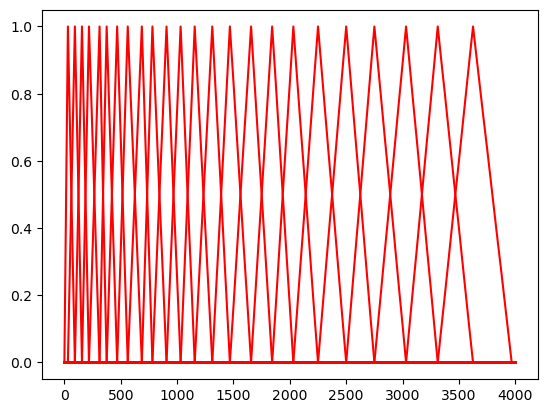

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def melbankm(p, NFFT, fs, fl, fh, w=None):
    """
    计算Mel滤波器组
    :param p: 滤波器个数
    :param n: 一帧FFT后的数据长度
    :param fs: 采样率
    :param fl: 最低频率
    :param fh: 最高频率
    :param w: 窗(没有加窗，无效参数)
    :return:
    """
    bl = 1125 * np.log(1 + fl / 700)  # 把 Hz 变成 Mel
    bh = 1125 * np.log(1 + fh / 700)
    B = bh - bl  # Mel带宽
    y = np.linspace(0, B, p + 2)  # 将梅尔刻度等间隔
    Fb = 700 * (np.exp(y / 1125) - 1)  # 把 Mel 变成Hz
    W2 = int(NFFT / 2 + 1)
    df = fs / NFFT
    freq = [int(i * df) for i in range(W2)]  # 采样频率值
    bank = np.zeros((p, W2))
    for k in range(1, p + 1):
        f0, f1, f2 = Fb[k], Fb[k - 1], Fb[k + 1]
        n1 = np.floor(f1 / df)
        n2 = np.floor(f2 / df)
        n0 = np.floor(f0 / df)
        for i in range(1, W2):
            if n1 <= i <= n0:
                bank[k - 1, i] = (i - n1) / (n0 - n1)
            elif n0 < i <= n2:
                bank[k - 1, i] = (n2 - i) / (n2 - n0)
            elif i > n2:
                break
        plt.plot(freq, bank[k - 1, :], 'r')
    plt.savefig('images/mel.png')
    return bank


if __name__ == '__main__':
    melbankm(24, 256, 8000, 0, 4000)



## MFCC计算
MFCC的计算过程可以表示为：

![mfcc](images/mfcc.png)

### 预处理
预处理包括预加重，分帧，加窗函数
 - 预加重
  由于声门脉冲的频率响应曲线接近于一个二阶低通滤波器，口腔辐射响应也接近一个低阶高通滤波器，预加重的目的是为了补偿高频分量的损失，提升高频分量。
  $$H(z)=1-az^{-1}$$

 - 分帧
  分帧是将信号分成一个一个的短时片段。每帧之间有重叠部分。

 - 加窗
  加窗是为了减少频域中的泄露，对每帧语音信号乘以窗函数。

### FFT

对每帧信号进行FFT变换，从时域数据转化为频域数据：
$$X(i,k)=FFT(X_i(m))$$

### 计算谱线能量
对每帧FFT后的数据计算普选的能量：
$$E(i,k)=[X_i(k)]^2$$

### 计算通过Mel滤波器的能量
将求出的每帧谱线能量通过Mel滤波器，并计算在Mel滤波器中的能量。在频域中，相当于把每帧的能量谱$E(i,k)$与Mel滤波器的频率响应$H_m(k)$相乘相加：
$$S(i,m)=\sum\limits_{k=0}^{N-1}E(i,k)H_m(k),0 \leqslant m <M$$

### 计算DCT倒谱
序列$x(n)$的FFT倒谱$\hat x(n)$为：
$$\hat x(n)=FFT^{-1}[\hat X(k)]$$

其中$\hat X(k)=\ln[FFT(x(n))]=\ln(X(k))$。由之前的公式可知，DCT的计算方法为：
$$X(k)=\sqrt{\frac{2}{N}}\sum\limits_{n=0}^{N-1}C(k)x(n)\cos(\frac{(2n+1)k\pi}{2N}),k=0,1,...,N-1\tag{DCT}$$

所以求DCT倒谱实际上就是将DCT取对数后求FFT逆变换。MFCC是将Mel滤波器的能量取对数后计算DCT:
$$mfcc(i,n)=\sqrt{\frac{2}{M}}\sum\limits_{n=0}^{M-1}\log [S_i(i,m)]\cos[\frac{(2m+1)n\pi}{2M}],n=0,1,...,N-1$$

其中$S_i(i,m)$是Mel滤波器计算输出，$m$是指第$m$个滤波器（一共M个），i是指第i帧，n是DCT后的谱线。

借助numpy与前面写过的部分函数实现mfcc计算方法为：

In [2]:
def Nmfcc(x, fs, p, frameSize, inc):
    """
    计算mfcc系数
    :param x: 输入信号
    :param fs: 采样率
    :param p: Mel滤波器组的个数
    :param frameSize: 分帧的每帧长度
    :param inc: 帧移
    :return:
    """
    # bank = melbankm(p, frameSize, fs, 0, 0.5 * fs, 0)
    # 预处理-预加重
    xx = lfilter([1, -0.9375], [1], x)
    # 预处理-分幀
    xx = enframe(xx, frameSize, inc)
    # 预处理-加窗
    xx = np.multiply(xx, np.hanning(frameSize))
    # 计算FFT
    xx = np.fft.fft(xx)
    # 计算能量谱
    xx = np.multiply(np.abs(xx), np.abs(xx))
    # 计算通过Mel滤波器的能量
    xx = xx[:, :frameSize // 2 + 1]
    bank = melbankm(p, frameSize, fs, 0, 0.5 * fs, 0)
    ss = np.matmul(xx, bank.T)
    # 计算DCT倒谱
    n_dct = 12
    M = bank.shape[0]
    m = np.array([i for i in range(M)])
    mfcc = np.zeros((ss.shape[0], n_dct))
    for n in range(n_dct):
        mfcc[:, n] = np.sqrt(2 / M) * np.sum(np.multiply(np.log(ss), np.cos((2 * m - 1) * n * np.pi / 2 / M)), axis=1)
    return mfcc

## 线性预测分析


一个简化的语音模型可以看做一个数字滤波器：
$$H(z)=\frac{S(z)}{U(z)}=\frac{G}{1-\sum\limits_{i=1}^pa_iz_i^{-1}}$$

这里$s(n)$和$u(n)$之间的关系可以用差分方程来表示：
$$s(n)=\sum\limits_{i=1}^pa_is(n-1)+Gu(n)$$

系统$\hat s(n)=\sum\limits_{i=1}^pa_is(n-1)$是线性预测器。$\hat s(n)$是$s(n)$的估计值。由过去的$p$个值线性组合得到的。$a_i(i=1,2,...,p)$是线性预测系数，预测误差表示为：
$$e(n)=s(n)-\hat s(n)=s(n)-\sum\limits_{i=1}^pa_is(n-i)$$

预测的二次方误差为：
$$E=\sum_ne^2(n)=\sum_n[s(n)-\hat s(n)]^2=\sum_n[s(n)-\sum\limits_{i=1}^pa_is(n-i)]^2$$

显然预测最准确的话，那么误差$E$要最小。要让参数$a_i$的取值让$E$最小化，要:
$$\frac{\partial E}{\partial a_j}=0,(1\leqslant j \leqslant p)$$

$$\begin{array}{ll}
\frac{\partial E}{\partial a_j}&=\{\sum_n[s(n)-\sum\limits_{i=1}^pa_is(n-i)]^2\}'\\
&=\sum_n\{2(s(n)-\sum\limits_{i=1}^pa_is(n-i))[s(n)-\sum\limits_{i=1}^pa_is(n-i)]'\}\\
&=\sum_n\{2(s(n)-\sum\limits_{i=1}^pa_is(n-i))(1-s(n-j))\}\\
&=2\sum_n\{s(n)-\sum_{i=1}^pa_ix(n-i)+s(n)s(n-j)-\sum\limits_{i=1}^pa_is(n-i)s(n-j)\}\\
&=2\sum_ns(n)s(n-j)-2\sum\limits_{i=1}^pa_i\sum_ns(n-i)s(n-j)
\end{array}$$

如果定义：$\phi(j,i)=\sum_ns(n-i)s(n-j)$，那么$\frac{\partial E}{\partial a_j}=0$就可以写成：
$$\phi(j,0)=\sum\limits_{i=1}^pa_i\phi(j,i) \tag{求解方程}$$

带入误差方程可以有：
$$E=\phi(0,0)-\sum_{i=1}^pa_i\phi(0,i)\tag{最小误差方程}$$

所以，最小误差是由一个固定分量$\phi(0,0)$和依赖于预测系数的分量$\sum_{i=1}^pa_i\phi(0,i)$组成的。

## 线性预测的自相关解法
自相关解法是$s(n)$在$0 \leqslant n \leqslant N-1$以外的值都是零，等同于假设了$s(n)$经过了有限长度的窗，就可以用p个方程来解有p个未知数的方程组了。定义：
$$r(j)=\sum_{n=0}^{N-1}s(n)s(n-j),1\leqslant j \leqslant p$$

那么$\phi(j,i)$等效于$r(j-i)$,由于自相关是偶函数，所以有：
$$\phi(j,i)=r(|j-i|)$$

所以求解方程为：
$$r(j)=\sum_{i=1}^pa_ir(|j-i|),1\leqslant j \leqslant p$$

最小误差方程为：
$$E=r(0)-\sum_{i=1}^pa_ir(i)$$

将$\phi(j,i)=r(|j-i|)$展开有：
$$\begin{bmatrix}r(0)&r(1)&r(2)&...&r(p-1)\\r(1)&r(0)&r(1)&...&r(p-2)\\r(2)&r(1)&r(0)&...&r(p-3)\\...&...&...&...&...\\r(p-1)&r(p-2)&r(p-3)&...&r(0)\end{bmatrix}\begin{bmatrix}a_1\\a_2\\a_3\\...\\a_p\end{bmatrix}=\begin{bmatrix}r(1)\\r(2)\\r(3)\\...\\r(p)\end{bmatrix}$$

这种沿着主对角对称，并任何一条与主对角线平行的线上的值都相等的矩阵叫Toeplitz矩阵，这种方程叫Yule-Walker方程。可以采用递归方法求解。
计算的步骤：
 - 当$i=0$时，$E_0=r(0),a_0=1$;
 - 对于第$i$次递归($i=1,2,...,p$):
  $$k_i=\frac{1}{E_{i-1}}[r(i)-\sum_{j=1}^{i-1}a_j^{i-1}r(j-i)]$$

  $$ia_i^{(i)}=k_i$$
  
  对于$j=1$到$i-1$:
  $$a_j^{(i)}=a_j^{i-1}-k_ia_{i-j}^{(i-1)}$$

  $$E_i=(1-k_i^2)E_{i-1}$$
 
 - 增益G为：

$$G=\sqrt{E_p}$$

递归得到：
$$E_p=r(0)\prod_{i=1}^p(1-k_i^2)$$

## 其他参数

#### 预测误差及其自相关
预测误差为：
$$e(n)=s(n)-\sum_{i=1}^pa_is(n-i)$$

预测误差的自相关为：
$$R_e(m)=\sum_{n=0}^{N-1-m}e(n)e(n+m)$$

#### 反射系数和声道面积
反射系数$k_i$在低速率语音编码/语音合成/语音识别和说话人识别等许多领域都是非常重要的特征。
$$\begin{array}{ll}
    a_j^{(i)}=a_j^{i-1}-k_ia_{i-j}^{(i-1)}\\
    a_{i-j}^{(i)}=a_{i-j}^{i-1}-k_ia_{j}^{(i-1)}
\end{array}$$

可以解出：
$$a_{j}^{i-1}=(a_j^{(i)}+a_j^{(i)}a_{i-j}^{(i)})/(1-k_i^2)$$

由线性预测系数可以反解出反射系数。声道可以被模拟成一系列截面积不等的无损声道级联。反射系数反应了声波在各管道界面处的反射量：
$$k_i=\frac{A_{i+1}-A_i}{A_{i+1}+A_i}$$

同样可以反解出：
$$\frac{A_i}{A_{i+1}}=\frac{1-k_i}{1+k_i}$$

### 线性预测频谱
一帧信号$x(n)$模型可以转化为一个$p$阶的线性预测模型。当$z=e^{jw}$时，能得到线性预测系数的频谱：
$$H(e^{jw})=\frac{1}{1-\sum_{n=1}^pa_nz^{-jwn}}$$

不考虑激励和辐射时，$H(e^{jw})$就是$X(e^{jw})$的包络线。

### 线性预测倒谱
语音信号的倒谱可以通过对信号做傅里叶变换，取模的对数，再求傅里叶逆变换得到。由于频率响应$H(e^{iω})$反映声道的频率响应和被分析信号的谱包络，因此用$\log|H(e^{iw})|$做傅里叶拟变换得到线性预测倒谱系数（Linear Prediction Cepstrum Coeffient, LPCC）。

更根据同态处理法有：$\hat H(z)=\log H(z)$,$\hat H(z)$可以写成级数展开的形式：
$$\hat H(z)=\sum_{n=1}^{+\infin}\hat h(n)z^{-n}$$

对上式同时对$z^{-1}$求导：
$$\frac{\partial }{\partial z^{-1}}\frac{1}{1-\sum\limits_{i=1}^pa_iz^{-i}}=\frac{\partial }{\partial z^{-1}}\sum\limits_{n=1}^{+\infin}\hat h(n)z^{-n}$$

解为：
$$(1-\sum\limits_{i=1}^pa_iz^{-1})\sum\limits_{n=1}^{+\infin}n\hat h(n)z^{-n+1}=\sum\limits_{n=1}^{+\infin}ia_iz^{-i+1}$$

令上市两边的$z$各次幂的系数分别相等，得到$\hat h(n)$和$a_i$之间的递推关系：
$$\left \{\begin{array}{ll}
    \hat h(1)=a_1&\\
    \hat h(n)=a_n+\sum_{i=1}^{n-1}(1-\frac{i}{n})a_i\hat h(n-i)&1<n\leqslant p\\
    \hat h(n)=\sum_{i=1}^{n-1}(1-\frac{i}{n})a_i\hat h(n-i)&n>p
\end{array}\right.$$

In [4]:
from utils.soundBase import *
from utils.lpc import *
from scipy.signal import lfilter

# data, fs = soundBase('./data/C3_5_y.wav').audioread()
fs, data = wavfile.read('./data/C3_5_y.wav') 
L = 240
x = data[8000:8000 + L]
x = (x - np.mean(x)) / np.std(x)
p = 12
ar, G = lpc_coeff(x, p)
b = np.zeros(p + 1)
b[0] = 1
b[1:] = -ar[1:]
est_x = lfilter(b, 1, x)
plt.subplot(2, 1, 1)
plt.plot(x)
plt.subplot(2, 1, 2)
plt.plot(est_x)
plt.savefig('images/lpc.png')
plt.close()



![lpc](images/lpc.png)


In [5]:
from utils.soundBase import *
from utils.lpc import *

fs, data = wavfile.read('./data/C3_5_y.wav') 
L = 240
p = 12
x = data[8000:8000 + L]
ar, G = lpc_coeff(x, p)
nfft = 512
W2 = nfft // 2
m = np.array([i for i in range(W2)])
Y = np.fft.fft(x, nfft)
Y1 = lpcff(ar, W2)
plt.subplot(2, 1, 1)
plt.plot(x)
plt.subplot(2, 1, 2)
plt.plot(m, 20 * np.log(np.abs(Y[m])))
plt.plot(m, 20 * np.log(np.abs(Y1[m])))
plt.savefig('images/lpcff.png')
plt.close()

/home/quant/myWork/data_analysis/Python_DataAnalysis/utils/lpc.py:35: RuntimeWarning: invalid value encountered in sqrt
  G = np.sqrt(Ep[p - 1])


![lpcff](images/lpcff.png)


/home/quant/myWork/data_analysis/Python_DataAnalysis/utils/lpc.py:35: RuntimeWarning: invalid value encountered in sqrt
  G = np.sqrt(Ep[p - 1])
/home/quant/miniconda3/envs/da310/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


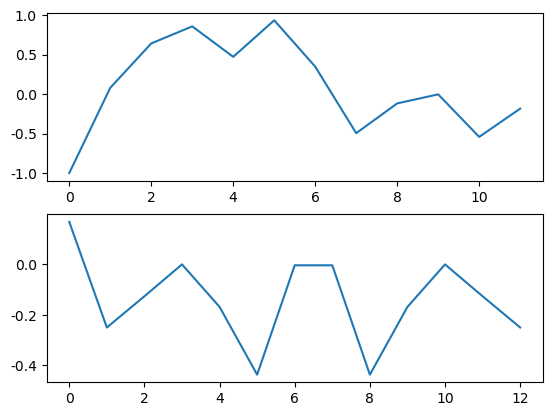

In [6]:
from utils.soundBase import *
from utils.lpc import *
from utils.倒谱计算 import *

fs, data = wavfile.read('./data/C3_5_y.wav') 
L = 240
p = 12
x = data[8000:8000 + L]
ar, G = lpc_coeff(x, p)

lpcc1 = lpc_lpccm(ar, p, p)
lpcc2 = rcceps(ar)
plt.subplot(2, 1, 1)
plt.plot(lpcc1)
plt.subplot(2, 1, 2)
plt.plot(lpcc2)
plt.show()


由于$A(z)=1-\sum\limits_{i=1}^pa_iz^{-1}$作为线性预测误差滤波器，其倒数$H(z)=1/A(z)$为线性预测合成滤波器，这个滤波器常被用于重建语音。直接对$a_i$进行编码时，$H(z)$的稳定性得不到保障。使用线谱对（Line Spectrum Pair, LSP）作为线性预测的等价，可以提高其鲁棒性。

LSP通过求解$p+1$阶对称和反对称多项式的共轭复根得到。其中$p+1$阶的对称和反对称多项式表示为：
$$\begin{array}{lc}
    P(z)=A(z)+z^{-(p+1)}A(z^{-1})\\Q(z)=A(z)-z^{-(p+1)}A(z^{-1})
\end{array}$$

其中：
$$z^{-(p+1)}A(z^{-1})=z^{-(p+1)}-a_1z^{-(p)}-a_2z^{-(p-1)}-...a_pz^{-1}$$
如果用$\omega_i$和$\theta_i$分别表示$P(z)$和$Q(z)$的第$i$个根。有：
$$\begin{array}{lc}
    P(z)=(1+z^{-1})\prod_{i=1}^{p/2}(1-2\cos \omega_iz^{-1}+z^{-2})\\
    Q(z)=(1-z^{-1})\prod_{i=1}^{p/2}(1-2\cos \theta_iz^{-1}+z^{-2})
\end{array}$$

$\omega_i$和$\theta_i$就是LSP系数对应的线谱频率（LSF）。由于LSP参数成对出现，并且反应信号的频谱特性，所以被称为线谱对。

更加定义可以很简单将LSP转化为LPC:
$$A(z)=\frac{1}{2}[P(z)+Q(z)]$$